In [1]:
### archivos para importar
import sqlite3 as sq
import pandas as pd
from collections import Counter
import random as rm
import source as so
import pycircstat
import pycircular
import matplotlib.pyplot as plt
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import sqlmanage as manage
import ecopy as ep
import scipy.stats as scs

# Set Data Base

In [2]:
incidental=pd.read_excel("./incidentales_Material_Supplementario.xlsx")

# Obtain the summatory of each forest type

In [24]:
proyecto1a=incidental
# realizamos el conteo por tipo
por_tipo=so.tipo_bosque(proyecto1a, criterio="species", criterio2="habitat", criterio3=["CCR","PCR","SLR"])
# obtenemos la carpeta con la suma total por tipo de bosque
por_tipo["suma"]=por_tipo["CCR"]+por_tipo["PCR"]+por_tipo["SLR"]

# Hourly temporary segreggation Analysis

C:\Users\amaru\anaconda3\envs\data\Lib\site-packages\pycircstat\descriptive.py:144: UserWarning: Ties detected in median computation
  warnings.warn('Ties detected in median computation')


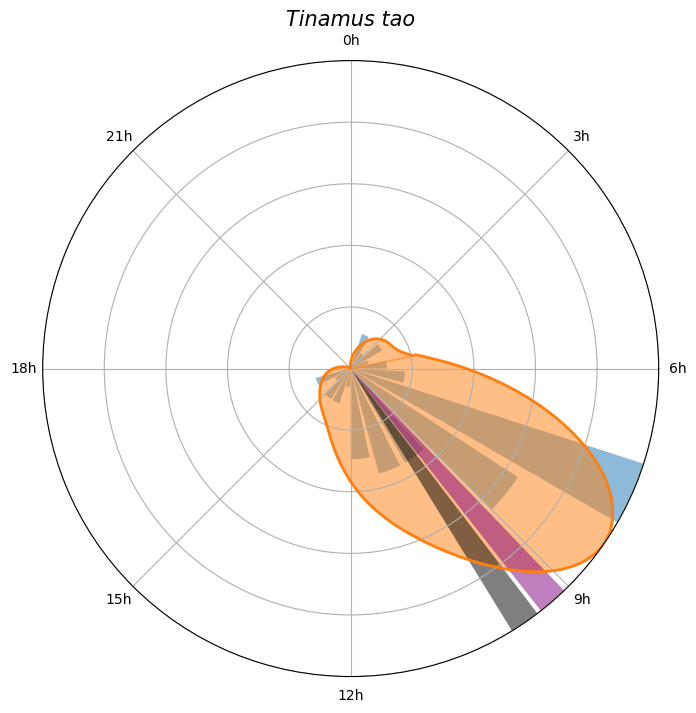

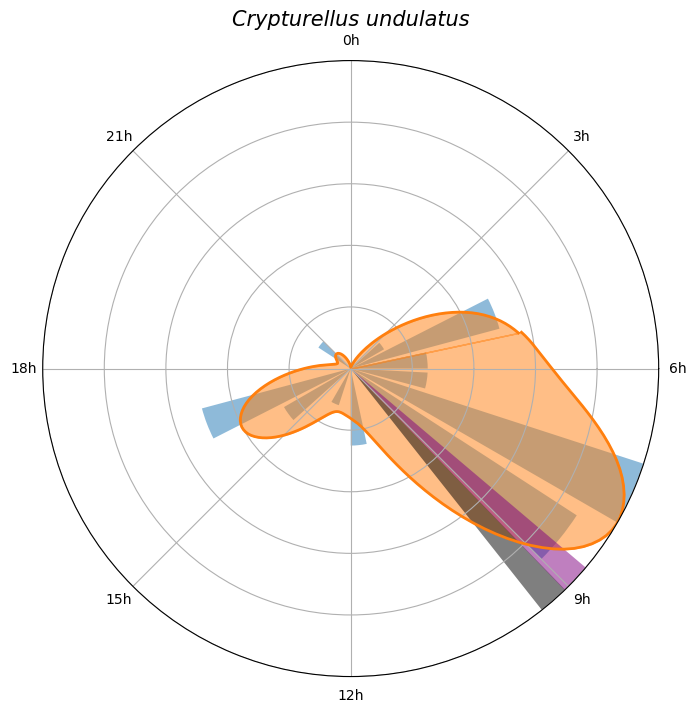

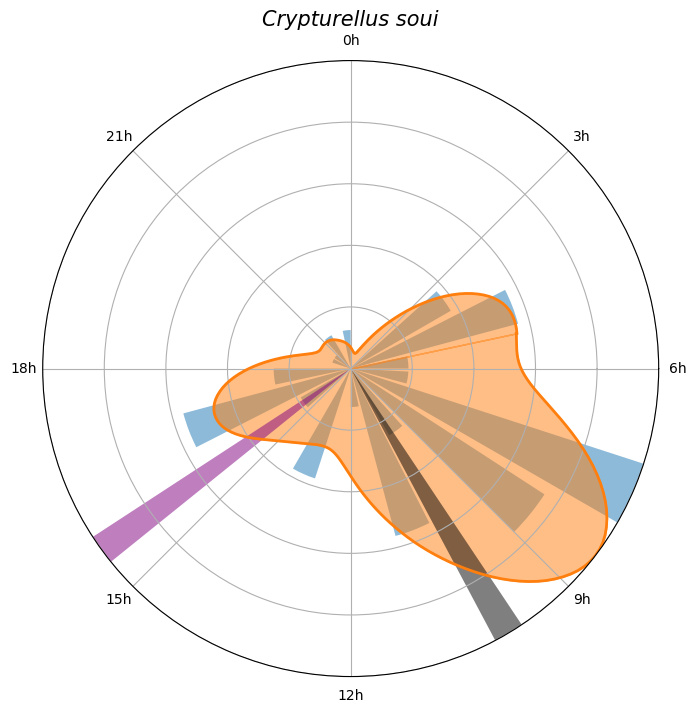

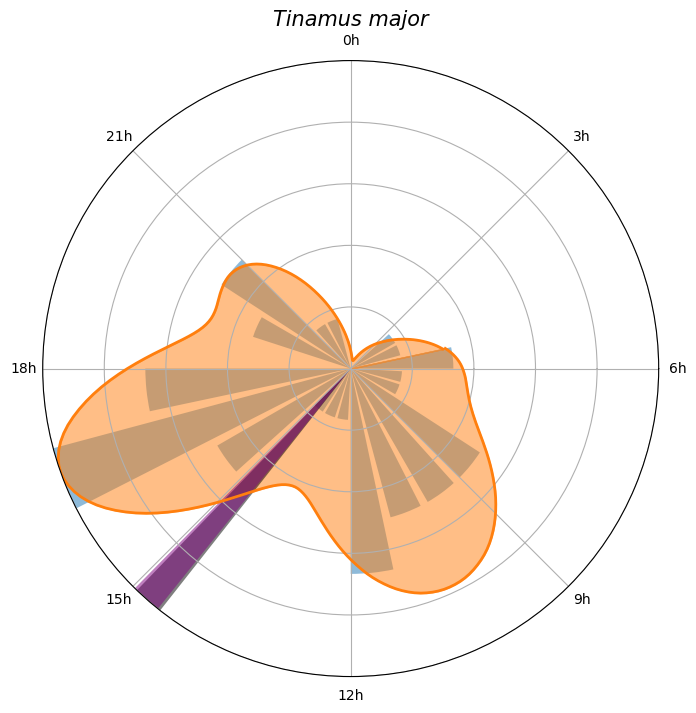

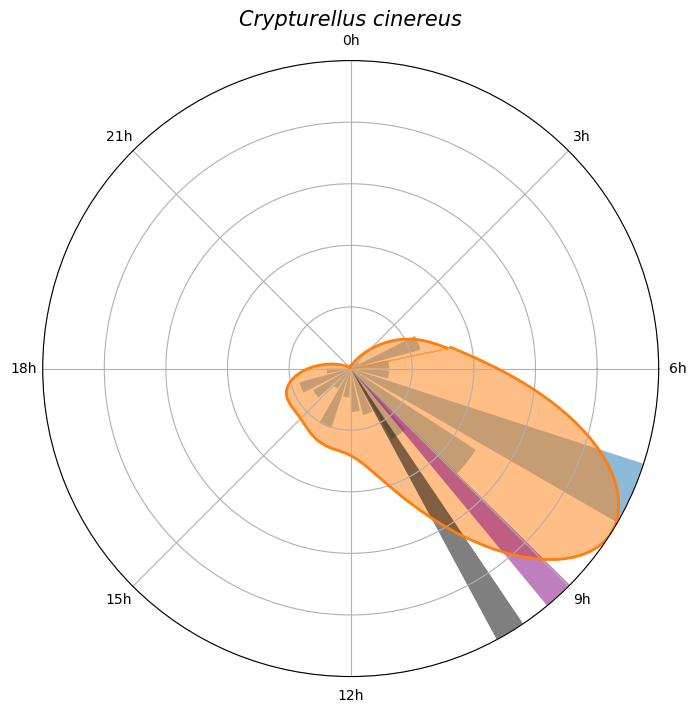

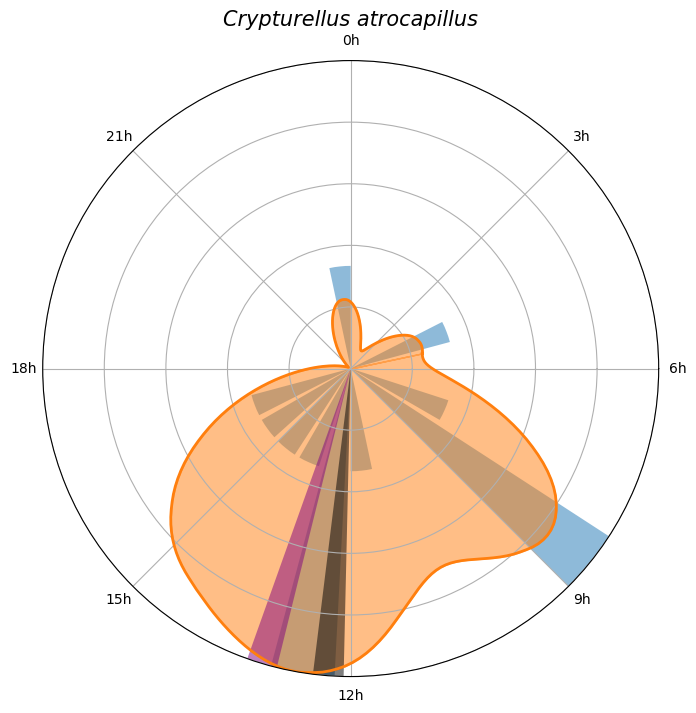

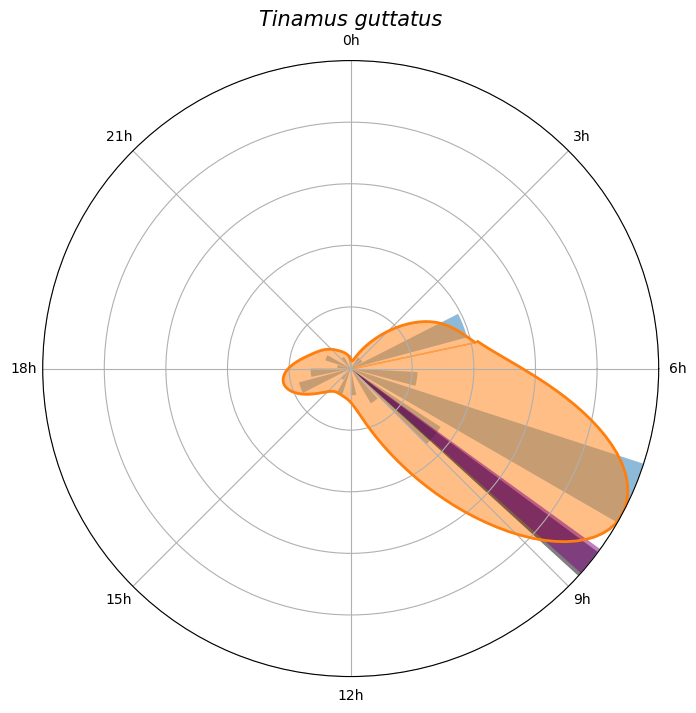

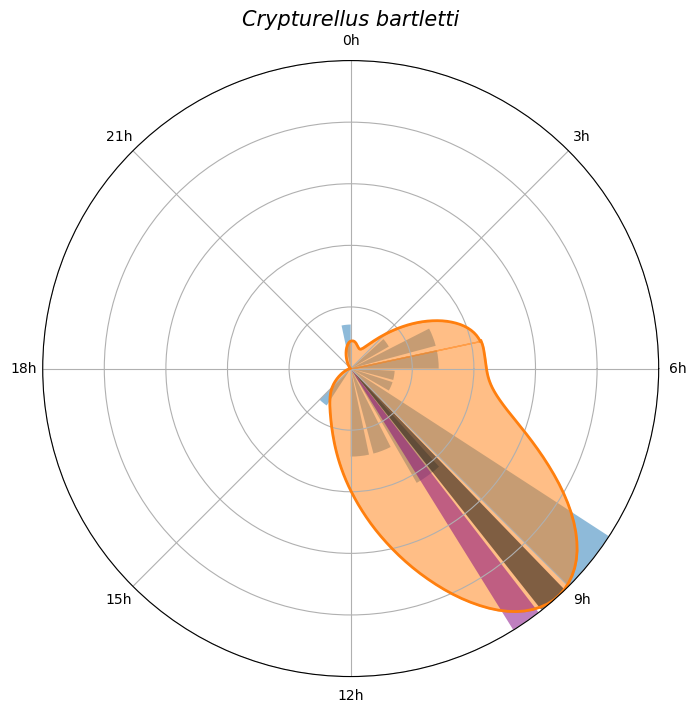

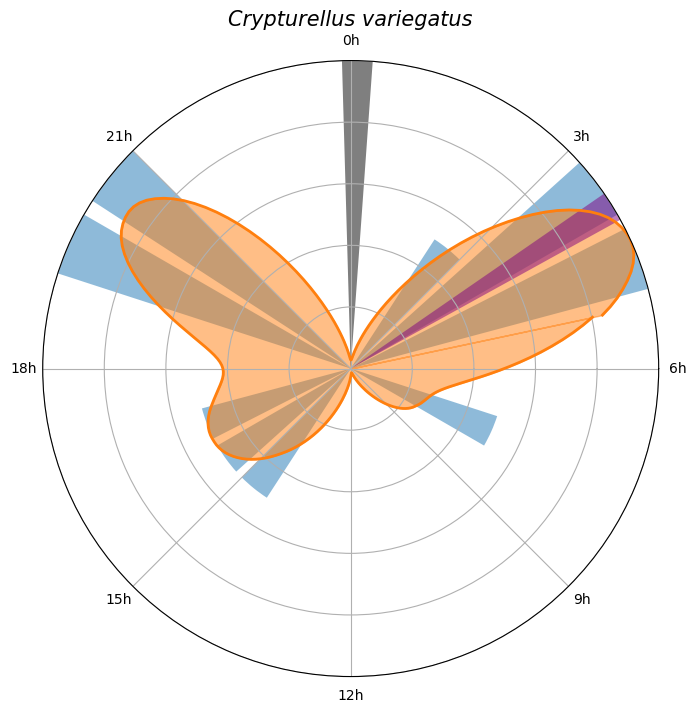

In [5]:
mediana=[]
medias=[]
datum=pd.DataFrame()
general={}
for e in proyecto1a["species"].unique():
    especie={}
    # se va a trabajar por especies
    pp=proyecto1a[proyecto1a["species"]==e]
    # el segmento de tiempos es por horas
    time_segment = 'hour' 
    #lista de las horas en las que se encuentran a esa especie
    time=pp["time"]
    # volvemos string to dates para poder usarlo
    x= pd.to_datetime(time) 
    # obtenemos la frecuencia y las horas en radianes de los estudiados para graficarlo
    freq_arr, times = pycircular.utils.freq_time(x, time_segment=time_segment) #### esta f(x) imput: datetime
    # grafico caada una de las frecuencias en diagrama de rosas
    #fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
    #nota no se puede usar media ni mediana aritmetica por lo que para solucionar el problema se esta midiendo la media de radianes y la mediana de radianes 
    #volvemos las horas en radianes
    radians = pycircular.utils._date2rad(x, time_segment='hour')
    # calculamos el mean periodic y la desviacion estanda
    mean, std = pycircular.stats.periodic_mean_std(radians)
    # calculamos la mediana
    median= pycircstat.median(radians)
    # calculamos el density kenel de los radianes estudiados
    y = pycircular.circular.kernel(radians.values)
    # graficamos la frecuencia y el density kernel en ambos de los graficos
    pycircular.plots.plot_kernel(freq_arr[:, 0], freq_arr[:, 1], y,time_segment=time_segment)
    # calculamos los valores de 24 datos que siguen el von mises distribucion
    #x, p = pycircular.stats.von_mises_distribution(mean, std, 24)
    # graficamos el von mises distribucion si es que lo tuviera
    #ax1 = pycircular.plots.clock_vonmises_distribution(ax1, mean, x, p) ##### dibuja la distribucion de von misses de cada cada una de las especies
    # hacemos el rayleight test para los radianes convertidos
    ray=pycircstat.rayleigh(radians.values)
    # se  grafica la media y la mediana, media  en blacno y mediana en purpura
    plt.bar(mean, 1, width=0.1, color="black", alpha=0.5)
    plt.bar(median, 1, width=0.1, color="purple", alpha=0.5)
    plt.title (f"{e}", fontstyle="italic",fontsize=15) 
    especie["freq_arr"]=freq_arr
    especie["times"]=times
    especie["radians"]=radians
    especie["mean"]=mean
    especie["std"]=std
    especie["median"]=median
    especie["rayley"]=ray
    general[e]=especie
    uno=pd.DataFrame({int(e[0]):[e[1]] for e in freq_arr}).transpose()
    uno.columns = [e]
    datum=pd.concat([datum, uno], axis=0)
    medias.append(mean)
    mediana.append(median)
    plt.legend().set_visible(False)
    plt.savefig(f"{e}.svg", dpi=300)

# General CMtest

In [ ]:
pycircstat.cmtest(general['Tinamus tao']['radians'],
                 general['Crypturellus undulatus']['radians'],
                 general['Crypturellus soui']['radians'],
                 general['Tinamus major']['radians'], #
                 general['Crypturellus cinereus']['radians'],
                 general['Crypturellus atrocapillus']['radians'],
                 general['Tinamus guttatus']['radians'], #
                 general['Crypturellus bartletti']['radians'],
                 general['Crypturellus variegatus']['radians'])

# CMtest avoiding species that are different

In [114]:
pycircstat.cmtest(general['Tinamus tao']['radians'],
                 general['Crypturellus undulatus']['radians'],
                 general['Crypturellus soui']['radians'],
                 general['Crypturellus cinereus']['radians'],
                 general['Crypturellus atrocapillus']['radians'],
                 general['Crypturellus bartletti']['radians'],
                 general['Crypturellus variegatus']['radians'])

(0.2833174049606222, 7.425075745167305)

In [12]:
# lista con los valores en radianes

In [25]:
lista=[general['Tinamus tao']['radians'].values,
       general['Crypturellus undulatus']['radians'].values,
       general['Crypturellus soui']['radians'].values,
       general['Tinamus major']['radians'].values,
       general['Crypturellus cinereus']['radians'].values,
       general['Crypturellus atrocapillus']['radians'].values,
       general['Tinamus guttatus']['radians'].values,
       general['Crypturellus bartletti']['radians'].values,
       general['Crypturellus variegatus']['radians'].values]

# Posthoc CMtest

In [ ]:
### calculo el cm tets de  dos en dos
df=pd.DataFrame()
for a in general.keys():
    values=[]
    for b in general.keys():
        p_value=pycircstat.cmtest(general[a]['radians'],general[b]['radians'])[0]
        values.append(float(p_value))
    df[a]=values

In [19]:
df.rename(index={0:'Tinamus tao',1:'Crypturellus undulatus',2:"Crypturellus soui",
                     3:"Tinamus major",4:"Crypturellus cinereus",5:"Crypturellus atrocapillus",
                      6:"Tinamus guttatus",
                     7:"Crypturellus bartletti",8:"Crypturellus variegatus"}, inplace=True)

In [21]:
df= df.rename(columns={'Tinamus tao':0,
                       'Crypturellus undulatus':1,
                       "Crypturellus soui":2,
                       "Tinamus major":3,
                       "Crypturellus cinereus":4,
                       "Crypturellus atrocapillus":5,
                       "Tinamus guttatus":6,
                       "Crypturellus bartletti":7,
                       "Crypturellus variegatus":8})

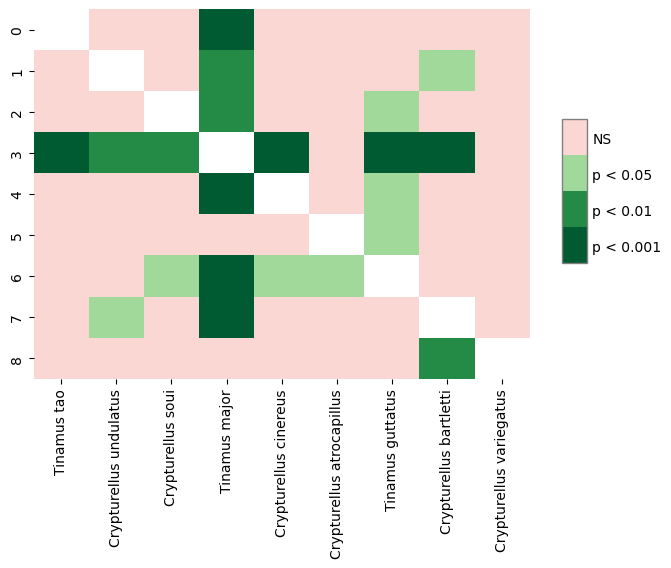

In [28]:
sp.sign_plot (df)
plt.savefig("heat_color.tiff", dpi=300, bbox_inches="tight")
plt.show()

# Using Tilt Database for the analysis

In [6]:
tilt=pd.read_excel("./material_suplementary_tilt.xlsx")

In [10]:
# realizo un codigo de los esfuerzos y los transectos realizados en cada esfuerzo
datos_unicos_referencia_date_df=pd.DataFrame({"codigo_effort":tilt["codigo_effort"].unique()})
datos_unicos_referencia_date_df["transect"]=[e[0:2] for e in datos_unicos_referencia_date_df ["codigo_effort"]]

# we equally efforts

In [12]:
Counter(datos_unicos_referencia_date_df["transect"])

Counter({'DT': 67, 'ST': 69, 'PT': 36})

In [13]:
rm.seed(100)

In [14]:
# seleceted 36 day of samples
sample={}
for e in datos_unicos_referencia_date_df["transect"].unique():
    medium=datos_unicos_referencia_date_df[datos_unicos_referencia_date_df["transect"]==e]
    efforts=medium["codigo_effort"]
    muestra=rm.sample(list(efforts), 36)
    sample[e]=muestra

In [15]:
#### creamos una lista con todos kos codigos que usaremos para seleccionar los datos
list_general=[]
for e in sample.keys():
    list_general=list_general+sample[e]
# seleccionamos los datos del codigo de tilt de cada uno de los grupos
final=pd.DataFrame()
for e in list_general:
    añadir=tilt[tilt["codigo_effort"]==e]
    final=pd.concat([final, añadir], axis=0)

# Analysis for forest Type

In [17]:
# counting for each foresy types
por_tipo2=so.tipo_bosque(final, criterio="species", criterio2="habitat", criterio3=["CCR","PCR","SLR"])
por_tipo2

,CCR,PCR,SLR
Crypturellus cinereus,49,30,16
Crypturellus undulatus,10,3,2
Crypturellus atrocapillus,1,0,1
Crypturellus soui,9,14,15
Tinamus major,3,12,11
Tinamus guttatus,6,8,2
Tinamus tao,9,6,6
Crypturellus bartletti,2,2,2
Crypturellus variegatus,1,2,2


In [18]:
# change the names of the analysis 
por_tipo2=por_tipo2.rename({'Crypturellus cinereus': 'C. cinereus', 
                  'Crypturellus undulatus': 'C. undulatus', 
                  'Crypturellus atrocapillus': 'C. atrocapillus',
                  "Crypturellus soui": "C. soui",
                  "Tinamus major": "T. major",
                  "Tinamus guttatus": "T. guttatus",
                  "Tinamus tao": "T. tao",
                  "Crypturellus bartletti": "C. barletti",
                  "Crypturellus variegatus": "C. variegatus"}, axis=0)


# Range Abundance Curves

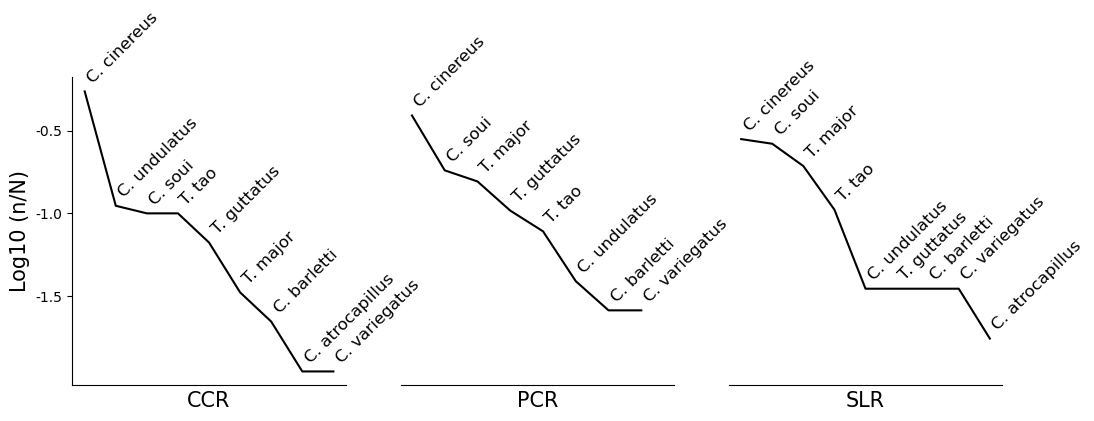

In [20]:
so.grafi_general_r_a(por_tipo2, tipos=["CCR", "PCR", "SLR"])
plt.savefig("rango_abundace.svg", dpi=300, bbox_inches="tight")

# Correspondence analysis

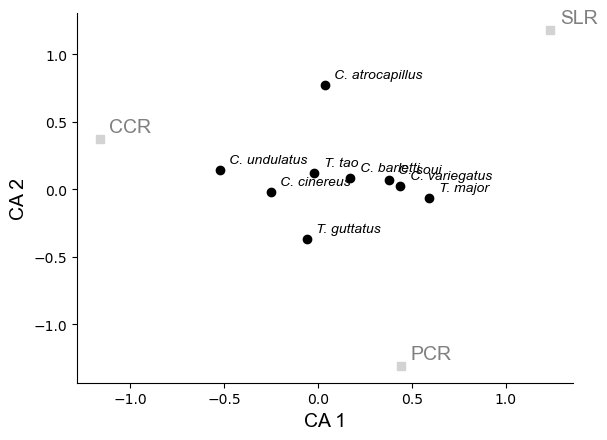

In [22]:
so.analisis_de_correspondencia(por_tipo2, annot=True)
plt.savefig("names_ca.svg")

# Diversity analysis

In [147]:
# se realizo un analisis de diversidad de hill
so. analisis_diversidad_alfa (por_tipo2, num_e=True).to_excel("diversidad_hill.xlsx")

# preferences for each forest type 

In [146]:
# ajuste de bondad G de Willians
conteos_especie=por_tipo2
suma=conteos_especie["CCR"]+conteos_especie["PCR"]+conteos_especie["SLR"]
sumita=suma/3
concatenado=pd.concat([sumita, sumita, sumita], axis=1)
concatenado.columns=["CCR","PCR","SLR"]
conteos_especie=conteos_especie.transpose()
concatenado=concatenado.transpose()
datita=pd.DataFrame()
for e in conteos_especie.columns:
    abi=scs.power_divergence(conteos_especie[e],concatenado[e],lambda_='log-likelihood')
    datita[e]=abi
datita=datita.transpose()
datita.columns=["G value", "p-value"]
datita

,G value,p-value
Crypturellus cinereus,17.692797,0.000144
Crypturellus undulatus,7.132827,0.028257
Crypturellus atrocapillus,1.621860,0.444444
Crypturellus soui,1.723139,0.422498
Tinamus major,6.689948,0.035261
Tinamus guttatus,3.977521,0.136865
Tinamus tao,0.824043,0.662310
Crypturellus bartletti,0.000000,1.000000
Crypturellus variegatus,0.436921,0.803755


In [14]:
proyecto1a=tilt

# Hourly temporary segregation

C:\Users\amaru\anaconda3\envs\data\Lib\site-packages\pycircstat\descriptive.py:144: UserWarning: Ties detected in median computation
  warnings.warn('Ties detected in median computation')


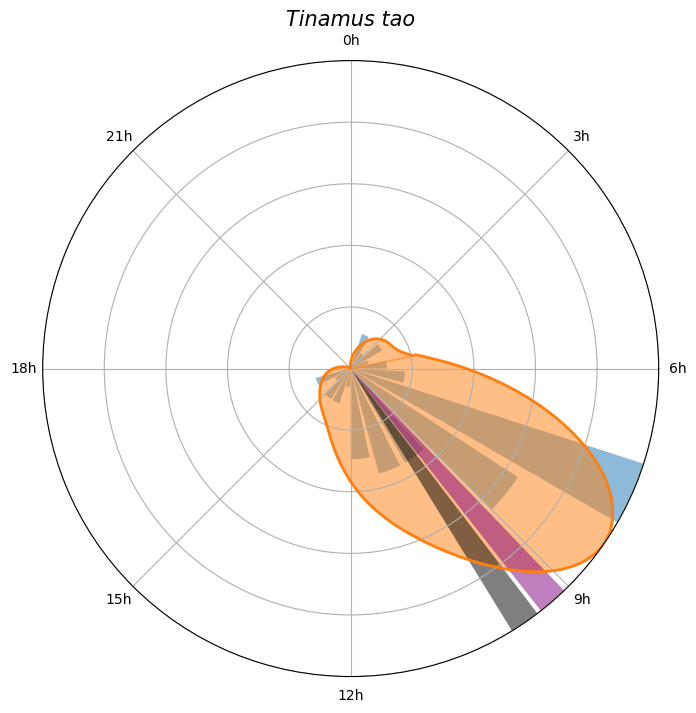

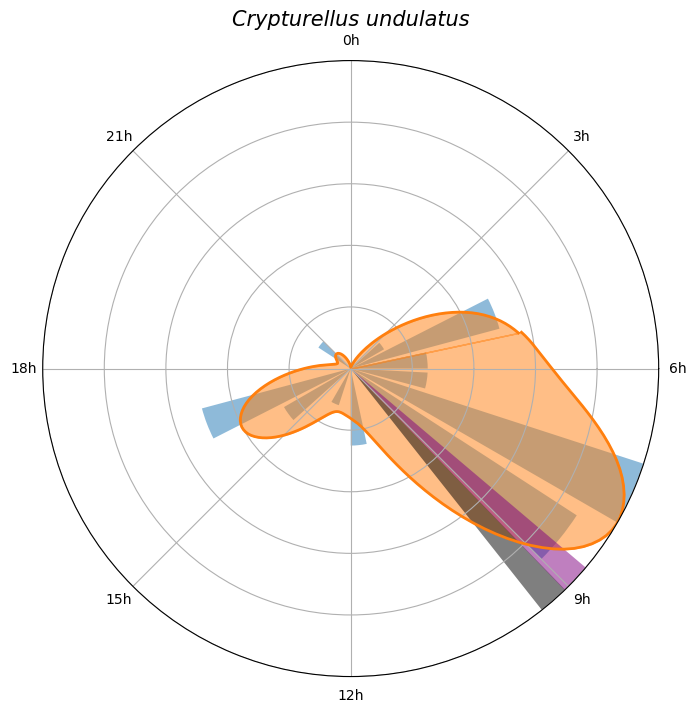

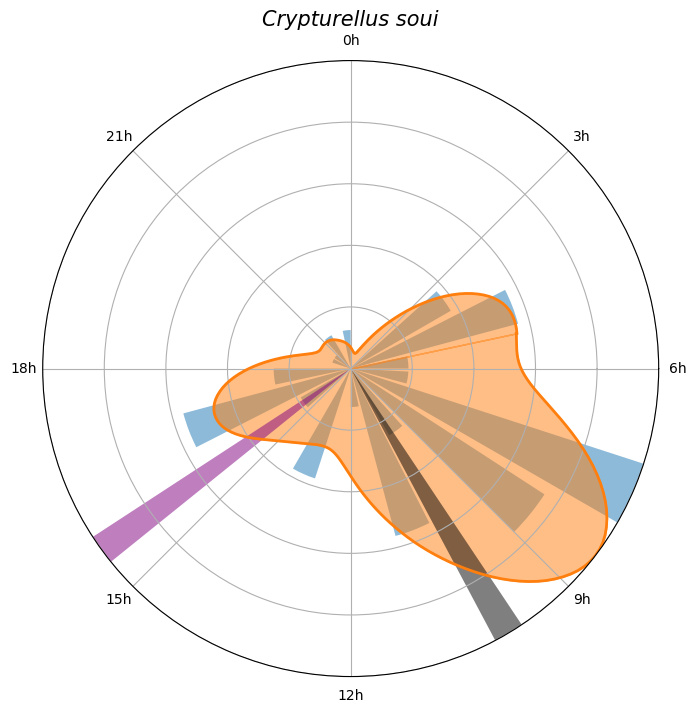

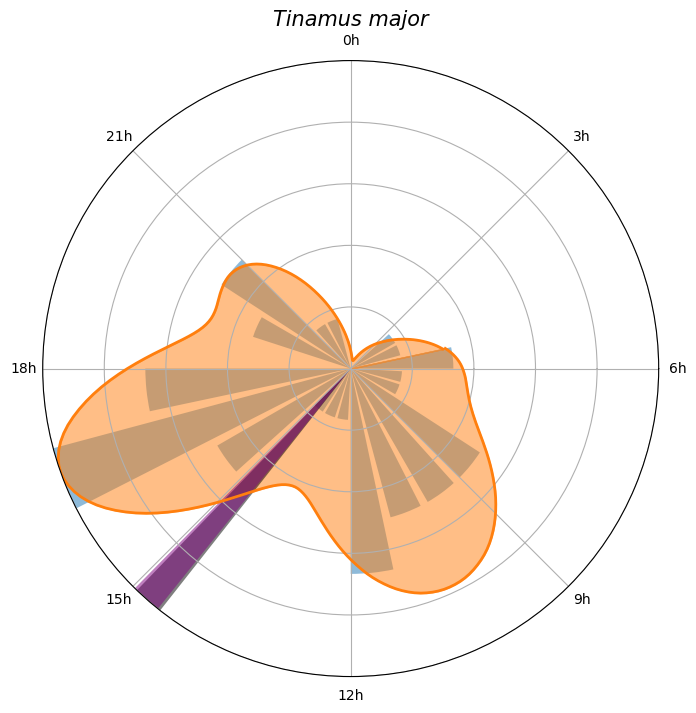

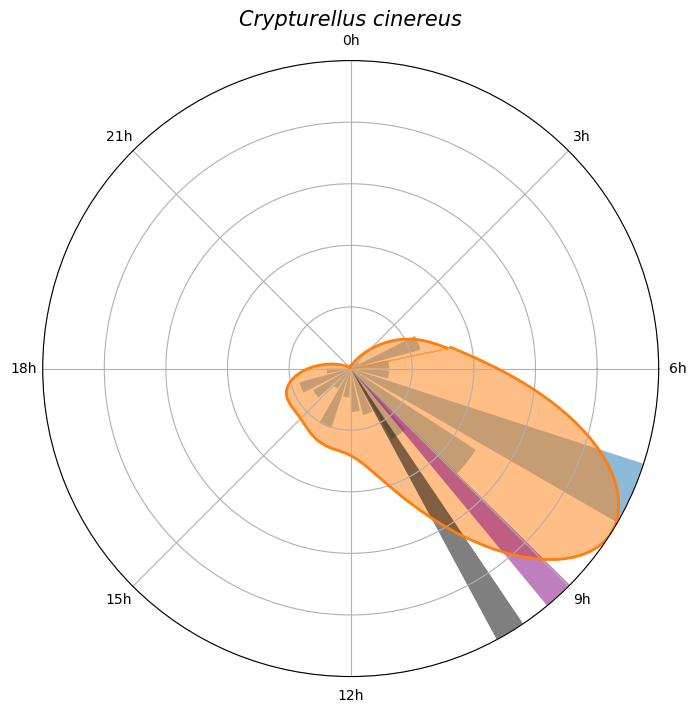

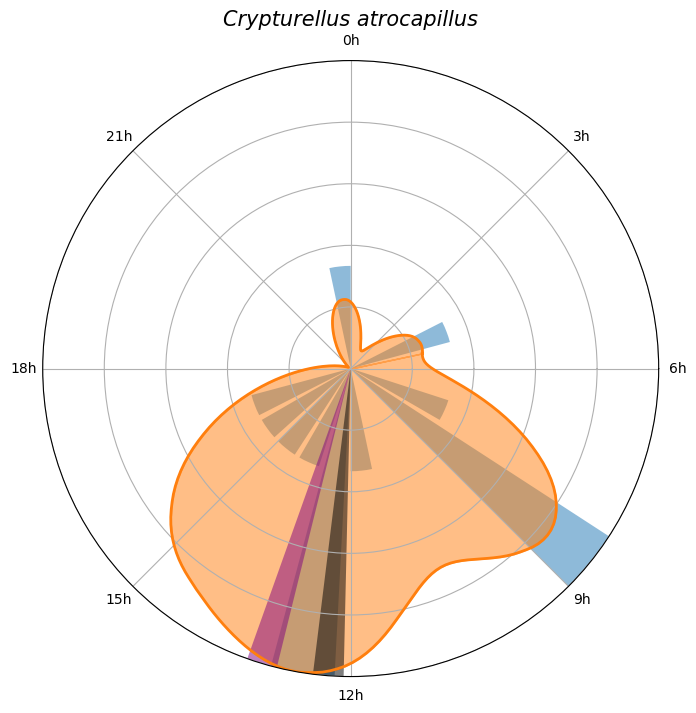

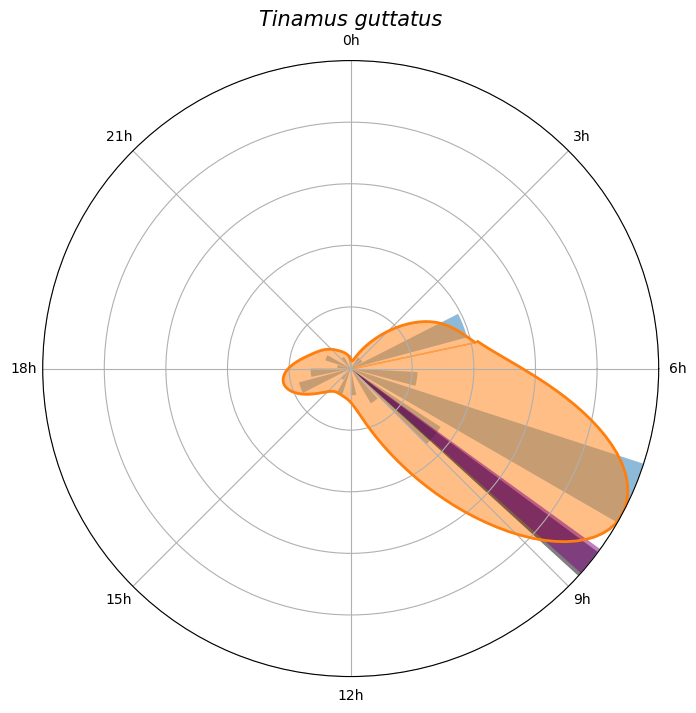

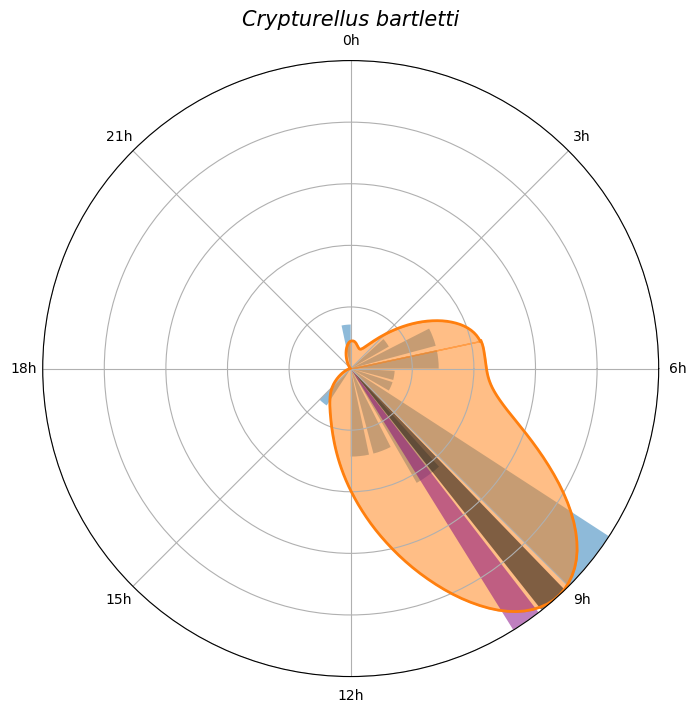

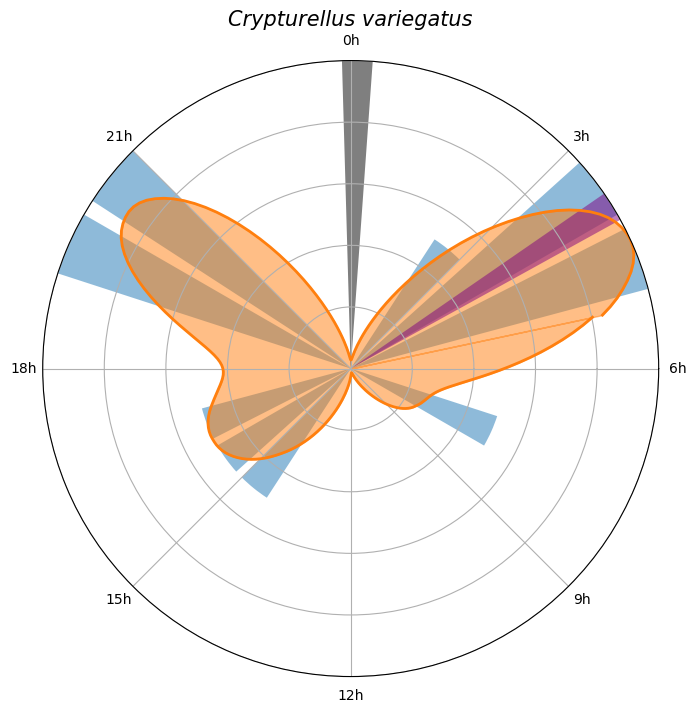

In [23]:
mediana=[]
medias=[]
datum=pd.DataFrame()
general={}
for e in proyecto1a["species"].unique():
    especie={}
    # se va a trabajar por especies
    pp=proyecto1a[proyecto1a["species"]==e]
    # el segmento de tiempos es por horas
    time_segment = 'hour' 
    #lista de las horas en las que se encuentran a esa especie
    time=pp["time"]
    # volvemos string to dates para poder usarlo
    x= pd.to_datetime(time) 
    # obtenemos la frecuencia y las horas en radianes de los estudiados para graficarlo
    freq_arr, times = pycircular.utils.freq_time(x, time_segment=time_segment) #### esta f(x) imput: datetime
    # grafico caada una de las frecuencias en diagrama de rosas
    #fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment)
    #nota no se puede usar media ni mediana aritmetica por lo que para solucionar el problema se esta midiendo la media de radianes y la mediana de radianes 
    #volvemos las horas en radianes
    radians = pycircular.utils._date2rad(x, time_segment='hour')
    # calculamos el mean periodic y la desviacion estanda
    mean, std = pycircular.stats.periodic_mean_std(radians)
    # calculamos la mediana
    median= pycircstat.median(radians)
    # calculamos el density kenel de los radianes estudiados
    y = pycircular.circular.kernel(radians.values)
    # graficamos la frecuencia y el density kernel en ambos de los graficos
    pycircular.plots.plot_kernel(freq_arr[:, 0], freq_arr[:, 1], y,time_segment=time_segment)
    # calculamos los valores de 24 datos que siguen el von mises distribucion
    #x, p = pycircular.stats.von_mises_distribution(mean, std, 24)
    # graficamos el von mises distribucion si es que lo tuviera
    #ax1 = pycircular.plots.clock_vonmises_distribution(ax1, mean, x, p) ##### dibuja la distribucion de von misses de cada cada una de las especies
    # hacemos el rayleight test para los radianes convertidos
    ray=pycircstat.rayleigh(radians.values)
    # se  grafica la media y la mediana, media  en blacno y mediana en purpura
    plt.bar(mean, 1, width=0.1, color="black", alpha=0.5)
    plt.bar(median, 1, width=0.1, color="purple", alpha=0.5)
    plt.title (f"{e}", fontstyle="italic",fontsize=15) 
    especie["freq_arr"]=freq_arr
    especie["times"]=times
    especie["radians"]=radians
    especie["mean"]=mean
    especie["std"]=std
    especie["median"]=median
    especie["rayley"]=ray
    general[e]=especie
    uno=pd.DataFrame({int(e[0]):[e[1]] for e in freq_arr}).transpose()
    uno.columns = [e]
    datum=pd.concat([datum, uno], axis=0)
    medias.append(mean)
    mediana.append(median)
    plt.legend().set_visible(False)
    plt.savefig(f"{e}.svg", dpi=300)